In [ ]:

!pip install transformers[sentencepiece]
!pip install datasets
!pip install evaluate
!pip install seqeval
!pip install transformers[torch]

In [1]:
print()

In [1]:
import torch
import numpy as np
from transformers import AutoModelForTokenClassification
import transformers
from datasets import load_dataset, Dataset, DatasetDict
from transformers import AutoTokenizer
import evaluate
from huggingface_hub import notebook_login
from tqdm.auto import tqdm

from torch.utils.data import DataLoader
from torch.optim import AdamW
from accelerate import Accelerator
from transformers import get_scheduler
from huggingface_hub import Repository, get_full_repo_name

In [3]:
notebook_login()

In [2]:
dataset = load_dataset("go_emotions")

In [3]:
print(dataset)
dataset['train']['labels']


LABELS = [
    'admiration',
    'amusement',
    'anger',
    'annoyance',
    'approval',
    'caring',
    'confusion',
    'curiosity',
    'desire',
    'disappointment',
    'disapproval',
    'disgust',
    'embarrassment',
    'excitement',
    'fear',
    'gratitude',
    'grief',
    'joy',
    'love',
    'nervousness',
    'optimism',
    'pride',
    'realization',
    'relief',
    'remorse',
    'sadness',
    'surprise',
    'neutral',
]

id2label = {idx:label for idx, label in enumerate(LABELS)}
label2id = {label:idx for idx, label in enumerate(LABELS)}

print(id2label)

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})
{0: 'admiration', 1: 'amusement', 2: 'anger', 3: 'annoyance', 4: 'approval', 5: 'caring', 6: 'confusion', 7: 'curiosity', 8: 'desire', 9: 'disappointment', 10: 'disapproval', 11: 'disgust', 12: 'embarrassment', 13: 'excitement', 14: 'fear', 15: 'gratitude', 16: 'grief', 17: 'joy', 18: 'love', 19: 'nervousness', 20: 'optimism', 21: 'pride', 22: 'realization', 23: 'relief', 24: 'remorse', 25: 'sadness', 26: 'surprise', 27: 'neutral'}


In [4]:
model_checkpoint = "bert-base-cased"
# model_checkpoint = "sarkerlab/SocBERT-final"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


In [ ]:
# Loading the fine-tuning dataset SST-5
from datasets import Value, Sequence, Features, ClassLabel
from transformers import DataCollatorWithPadding

dataset_sst5 = load_dataset('SetFit/sst5')
dataset_sst5 = dataset_sst5.rename_column("label", "labels")
print(dataset_sst5)

LABELS_sst5 = ['very negative', 'negative', 'neutral', 'positive', 'very positive']
id2label_sst5 = {idx:label for idx, label in enumerate(LABELS_sst5)}
label2id_sst5 = {label:idx for idx, label in enumerate(LABELS_sst5)}

def preprocess_function_sst5(examples):
  return tokenizer(examples["text"], truncation=True)

def tokenize_sst5(dataset):
  tokenized_dataset = dataset.map(preprocess_function_sst5, batched=True)
  data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
  return tokenized_dataset, data_collator

tokenized_dataset_sst5, data_collator_sst5 = tokenize_sst5(dataset_sst5)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'label_text'],
        num_rows: 8544
    })
    validation: Dataset({
        features: ['text', 'labels', 'label_text'],
        num_rows: 1101
    })
    test: Dataset({
        features: ['text', 'labels', 'label_text'],
        num_rows: 2210
    })
})


Map:   0%|          | 0/8544 [00:00<?, ? examples/s]

Map:   0%|          | 0/1101 [00:00<?, ? examples/s]

Map:   0%|          | 0/2210 [00:00<?, ? examples/s]

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import precision_score, recall_score

def compute_metrics_sst5(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    y_true, y_pred = labels, predictions
    accuracy_macro = accuracy_score(y_true=y_true, y_pred=y_pred)
    f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
    precision_macro = precision_score(y_true=y_true, y_pred=y_pred, average='macro')
    recall_macro = recall_score(y_true=y_true, y_pred=y_pred, average='macro')

    return {
        "precision": precision_macro,
        "recall": recall_macro,
        "f1": f1_macro,
        "accuracy": accuracy_macro,
    }


from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-cased",
    num_labels=5, id2label=id2label_sst5, label2id=label2id_sst5
)

training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    metric_for_best_model="f1",
    warmup_ratio = 0.2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset_sst5["train"],
    eval_dataset=tokenized_dataset_sst5["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator_sst5,
    compute_metrics=compute_metrics_sst5,
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.385100,1.163206,0.489142,0.467384,0.449247,0.490463
2,1.086900,1.230800,0.520528,0.490850,0.445320,0.477748
3,0.898200,1.185762,0.530681,0.501124,0.502499,0.520436
4,0.647500,1.388647,0.514013,0.472762,0.480961,0.503179
5,0.405800,1.812721,0.488080,0.487294,0.475290,0.490463
6,0.251500,2.408354,0.488175,0.467102,0.472236,0.485922
7,0.162400,3.149593,0.473656,0.463657,0.459293,0.482289
8,0.091400,3.539264,0.481382,0.464353,0.466548,0.489555
9,0.054700,3.850200,0.488259,0.456141,0.458665,0.493188
10,0.019700,3.894118,0.484535,0.462286,0.465417,0.489555


TrainOutput(global_step=5340, training_loss=0.46928461999928905, metrics={'train_runtime': 590.8447, 'train_samples_per_second': 144.607, 'train_steps_per_second': 9.038, 'total_flos': 2201098375898688.0, 'train_loss': 0.46928461999928905, 'epoch': 10.0})

In [ ]:
trainer.save_model('/content/drive/MyDrive/Assignment4_pretrained_sst5')

In [ ]:
trainer.evaluate(tokenized_dataset_sst5['test'])

{'eval_loss': 1.1728627681732178,
 'eval_precision': 0.52676476682599,
 'eval_recall': 0.48452798113003326,
 'eval_f1': 0.48451055274696186,
 'eval_accuracy': 0.5,
 'eval_runtime': 4.2661,
 'eval_samples_per_second': 518.042,
 'eval_steps_per_second': 32.583,
 'epoch': 10.0}

In [ ]:
# Fine-tuning on XED
from datasets import Value, Sequence, Features, ClassLabel, concatenate_datasets
from transformers import DataCollatorWithPadding

# Neutral is stored separately
dataset_xed = load_dataset('xed_en_fi', 'en_annotated')['train']
# dataset_xed_neutral = load_dataset('xed_en_fi', 'en_neutral')['train']
# dataset_xed = concatenate_datasets([dataset_xed, dataset_xed_neutral])
dataset_xed = dataset_xed.train_test_split(test_size=0.2)
print(dataset_xed)
LABELS_xed = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
id2label_xed = {idx:label for idx, label in enumerate(LABELS_xed)}
label2id_xed = {label:idx for idx, label in enumerate(LABELS_xed)}

def preprocess_function_xed(examples):
  text = examples["sentence"]
  encoding = tokenizer(text, truncation=True)
  label_mat = np.zeros((len(text), len(LABELS_xed))).astype(np.float32)
  for i in range(len(text)):
    for l in examples['labels'][i]:
      label_mat[i][l-1] = 1.0
  label_mat = [[float(i) for i in row]  for row in label_mat]
  encoding['labels'] = label_mat

  return encoding


def tokenize_xed(dataset):
  tokenized_dataset = dataset.map(preprocess_function_xed, batched=True)
  data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


  new_features = tokenized_dataset['train'].features.copy()
  new_features["labels"] = Sequence(Value("float32"))
  tokenized_dataset['train'] = tokenized_dataset['train'].cast(new_features)

  new_features = tokenized_dataset['test'].features.copy()
  new_features["labels"] = Sequence(Value("float32"))
  tokenized_dataset['test'] = tokenized_dataset['test'].cast(new_features)
  return tokenized_dataset, data_collator


tokenized_dataset_xed, data_collator_xed = tokenize_xed(dataset_xed)




DatasetDict({
    train: Dataset({
        features: ['sentence', 'labels'],
        num_rows: 14022
    })
    test: Dataset({
        features: ['sentence', 'labels'],
        num_rows: 3506
    })
})


Map:   0%|          | 0/14022 [00:00<?, ? examples/s]

Map:   0%|          | 0/3506 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/14022 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3506 [00:00<?, ? examples/s]

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import precision_score, recall_score

# Adapted from https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels):
    threshold = 0.3
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_macro_average = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
    precision_macro_average = precision_score(y_true=y_true, y_pred=y_pred, average='macro')
    recall_macro_average = recall_score(y_true=y_true, y_pred=y_pred, average='macro')

    roc_auc = roc_auc_score(y_true, y_pred, average = 'macro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_macro_average,
               'precision': precision_macro_average,
               'recall': recall_macro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p):
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result

from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-cased", problem_type="multi_label_classification",
    num_labels=8, id2label=id2label_xed, label2id=label2id_xed
)

training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=500,
    load_best_model_at_end=True,
    push_to_hub=False,
    metric_for_best_model="f1",
    warmup_ratio = 0.1
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset_xed["train"],
    eval_dataset=tokenized_dataset_xed["test"],
    tokenizer=tokenizer,
    data_collator=data_collator_xed,
    compute_metrics=compute_metrics,
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,F1,Precision,Recall,Roc Auc,Accuracy
500,0.438000,0.347751,0.478508,0.506933,0.486040,0.694431,0.243297
1000,0.338900,0.341411,0.506422,0.499581,0.531915,0.712168,0.291786
1500,0.306000,0.333440,0.518596,0.537701,0.524209,0.714420,0.326298
2000,0.270100,0.361240,0.513973,0.510471,0.542754,0.716795,0.303765
2500,0.236900,0.358402,0.522350,0.512199,0.555301,0.724712,0.314889
3000,0.179900,0.396886,0.517956,0.497274,0.551294,0.722145,0.322305
3500,0.167700,0.389111,0.523092,0.515919,0.540749,0.721016,0.335140
4000,0.121300,0.436419,0.522706,0.493426,0.558567,0.724628,0.323446
4500,0.113400,0.477357,0.518709,0.476143,0.577479,0.727514,0.306332
5000,0.086600,0.491869,0.512328,0.476148,0.560682,0.721675,0.312607


TrainOutput(global_step=8770, training_loss=0.14605761253983293, metrics={'train_runtime': 797.0944, 'train_samples_per_second': 175.914, 'train_steps_per_second': 11.002, 'total_flos': 1959997222727616.0, 'train_loss': 0.14605761253983293, 'epoch': 10.0})

In [ ]:
trainer.save_model('/content/drive/MyDrive/Assignment4_pretrained_xed')

In [5]:
from datasets import Value, Sequence, Features, ClassLabel
from transformers import DataCollatorWithPadding

def preprocess_function_goemotions(examples):
  text = examples["text"]
  encoding = tokenizer(text, truncation=True)
  label_mat = np.zeros((len(text), len(LABELS))).astype(np.float32)
  for i in range(len(text)):
    for l in examples['labels'][i]:
      label_mat[i][l] = 1.0
  label_mat = [[float(i) for i in row]  for row in label_mat]
  encoding['labels'] = label_mat

  return encoding


def tokenize_goemotions(dataset):
  tokenized_dataset = dataset.map(preprocess_function_goemotions, batched=True)
  data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


  new_features = tokenized_dataset['train'].features.copy()
  new_features["labels"] = Sequence(Value("float32"))
  tokenized_dataset['train'] = tokenized_dataset['train'].cast(new_features)

  new_features = tokenized_dataset['validation'].features.copy()
  new_features["labels"] = Sequence(Value("float32"))
  tokenized_dataset['validation'] = tokenized_dataset['validation'].cast(new_features)

  new_features = tokenized_dataset['test'].features.copy()
  new_features["labels"] = Sequence(Value("float32"))
  tokenized_dataset['test'] = tokenized_dataset['test'].cast(new_features)
  return tokenized_dataset, data_collator


tokenized_dataset, data_collator = tokenize_goemotions(dataset)


Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/5426 [00:00<?, ? examples/s]

In [6]:
import evaluate
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import precision_score, recall_score


# Adapted from https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels):
    threshold = 0.3
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_macro_average = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
    precision_macro_average = precision_score(y_true=y_true, y_pred=y_pred, average='macro')
    recall_macro_average = recall_score(y_true=y_true, y_pred=y_pred, average='macro')

    roc_auc = roc_auc_score(y_true, y_pred, average = 'macro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_macro_average,
               'precision': precision_macro_average,
               'recall': recall_macro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p):
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result

In [7]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
# model = AutoModelForSequenceClassification.from_pretrained(
#     "bert-base-cased", problem_type="multi_label_classification",
#     num_labels=28, id2label=id2label, label2id=label2id
# )

model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/Assignment4_pretrained_xed', problem_type="multi_label_classification",
    num_labels=28, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)


training_args = TrainingArguments(
    output_dir="my_model",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=1000,
    save_steps=1000,
    load_best_model_at_end=True,
    push_to_hub=False,
    metric_for_best_model="f1",
    warmup_ratio = 0.1
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/Assignment4_pretrained_xed and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([8]) in the checkpoint and torch.Size([28]) in the model instantiated
- classifier.weight: found shape torch.Size([8, 768]) in the checkpoint and torch.Size([28, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,F1,Precision,Recall,Roc Auc,Accuracy
1000,0.155100,0.140793,0.055390,0.086999,0.058161,0.519108,0.267232
2000,0.112800,0.104747,0.261950,0.332197,0.261630,0.622642,0.406561
3000,0.096900,0.093773,0.381953,0.421707,0.378378,0.679205,0.435311
4000,0.090200,0.091157,0.409294,0.444686,0.419746,0.699690,0.425175
5000,0.085900,0.088189,0.465876,0.487931,0.473109,0.725123,0.438076
6000,0.071600,0.088834,0.462013,0.492936,0.455348,0.716925,0.460007
7000,0.072200,0.089086,0.476655,0.503891,0.489502,0.733738,0.423148
8000,0.071900,0.088965,0.487326,0.488901,0.505855,0.741738,0.423701
9000,0.055000,0.096697,0.481226,0.474595,0.516253,0.746690,0.432363
10000,0.054800,0.094335,0.491672,0.510840,0.505920,0.740666,0.418909


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

TrainOutput(global_step=27140, training_loss=0.05125323125959409, metrics={'train_runtime': 1673.3557, 'train_samples_per_second': 259.419, 'train_steps_per_second': 16.219, 'total_flos': 8255418364089888.0, 'train_loss': 0.05125323125959409, 'epoch': 10.0})

In [ ]:
trainer.save_model('/content/drive/MyDrive/saved_xed1')

In [17]:
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/saved3')
model.to('cuda:0')

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [18]:
# print(dataset['test']['text'])
pred = []

for i in range(0, len(dataset['test']['text']), 8):
  test_dataset = tokenizer(dataset['test']['text'][i:(i+8)], return_tensors="pt", truncation=True, padding=True)

  test_dataset['input_ids'] = test_dataset['input_ids'].to('cuda:0')
  test_dataset['token_type_ids'] = test_dataset['token_type_ids'].to('cuda:0')
  test_dataset['attention_mask'] = test_dataset['attention_mask'].to('cuda:0')

  output = model(**test_dataset).logits
  pred.extend(output.cpu().detach().numpy())

pred = np.array(pred)


In [19]:
def multi_label_metrics(predictions, labels):
    threshold = 0.3
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_macro_average = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
    precision_macro_average = precision_score(y_true=y_true, y_pred=y_pred, average='macro')
    recall_macro_average = recall_score(y_true=y_true, y_pred=y_pred, average='macro')

    roc_auc = roc_auc_score(y_true, y_pred, average = 'macro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_macro_average,
               'precision': precision_macro_average,
               'recall': recall_macro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

true = tokenized_dataset['test']['labels']
multi_label_metrics(pred, true)


{'f1': 0.5623489785458006,
 'precision': 0.5240174672489083,
 'recall': 0.6067309211565808,
 'roc_auc': 0.791389659387577,
 'accuracy': 0.4035378662244334}

In [15]:
from sklearn.metrics import precision_score, recall_score
def multi_label_by_class(predictions, labels):
    threshold = 0.3
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    precision_list = []
    recall_list = []
    f1_list = []

    for i in range(len(y_pred[0])):
      precision_list.append(precision_score(np.array(y_true)[:,i], y_pred=np.array(y_pred)[:,i]))
      recall_list.append(recall_score(np.array(y_true)[:,i], y_pred=np.array(y_pred)[:,i]))
      f1_list.append(f1_score(y_true=np.array(y_true)[:,i], y_pred=np.array(y_pred)[:,i]))
    return precision_list, recall_list, f1_list

precision_list, recall_list, f1_list = multi_label_by_class(pred, true)
f1_list

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6612740141557129,
 0.8117443868739205,
 0.4840425531914894,
 0.3668005354752343,
 0.3919885550786838,
 0.4166666666666667,
 0.43059490084985835,
 0.5416078984485191,
 0.43661971830985913,
 0.29059829059829057,
 0.418848167539267,
 0.4372093023255815,
 0.4745762711864407,
 0.4085106382978724,
 0.6585365853658537,
 0.9158345221112697,
 0.0,
 0.6449704142011835,
 0.8008213552361396,
 0.2909090909090909,
 0.5947368421052631,
 0.5,
 0.24025974025974028,
 0.0,
 0.7050359712230215,
 0.5626911314984709,
 0.5472972972972973,
 0.6516675489677077]

In [ ]:
header = ['Text', 'True_label', 'True_label_id', 'Pred_label', 'Pred_label_id'] + LABELS
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(torch.Tensor(pred)).cpu().detach().numpy()
text = dataset['test']['text']
true_label_id = [str(label_list) for label_list in dataset['test']['labels']]
true_label = [str([id2label[l] for l in label_list ]) for label_list in dataset['test']['labels']]
pred_label_id = [np.nonzero(prob >= 0.3)[0].tolist() for prob in probs]
pred_label = [str([id2label[l] for l in label_list ]) for label_list in pred_label_id]
pred_label_id = [str(label_list) for label_list in pred_label_id]
print(np.array(text).shape)

print(probs[0])

results = np.hstack([np.array(text).reshape(-1,1), np.array(true_label).reshape(-1,1), np.array(true_label_id).reshape(-1,1), np.array(pred_label).reshape(-1,1), np.array(pred_label_id).reshape(-1,1), probs])
results = np.vstack([[header], results])

# np.savetxt('GoEmotions_prediction_results_updated.tsv', results, delimiter = '\t', fmt = '%s')

(5427,)
[1.56114344e-03 8.17581778e-04 1.30296010e-03 9.87239648e-04
 4.70537692e-03 1.35874795e-02 3.80286085e-03 2.64330534e-03
 3.97998188e-03 7.92066474e-03 2.08307081e-03 1.36322214e-03
 1.48572866e-03 9.75492643e-04 4.40244155e-04 9.84304701e-04
 6.28055073e-03 1.08775578e-03 9.76798952e-01 7.98426685e-04
 1.79443334e-03 4.74037981e-04 1.31928967e-02 5.37477143e-04
 2.04998434e-01 1.78954571e-01 2.07664282e-03 2.18927860e-02]


In [ ]:
for i in range(len(true_label[:5000])):
  print(text[i], true_label[i], pred_label[i])

In [ ]:
conf_mat = np.zeros((28,28))
true_label_id = [eval(l)  for l in true_label_id]
pred_label_id = [eval(l)  for l in pred_label_id]


for i in range(len(true_label_id)):
  for tl in true_label_id[i]:  # List of true labels
    for pl in pred_label_id[i]: # List of predicted labels
      conf_mat[tl, pl] += 1

# print(conf_mat)

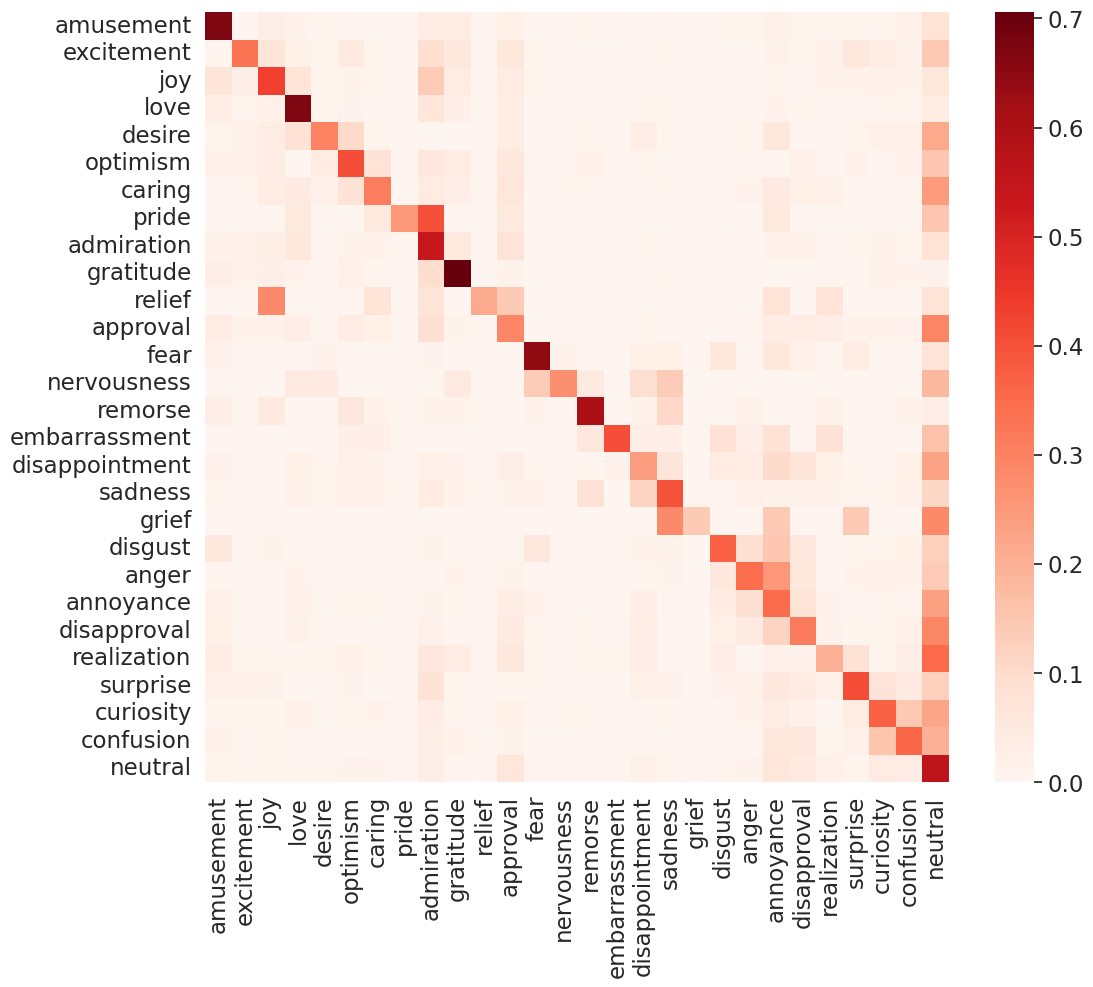

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

group = {
"positive": ["amusement", "excitement", "joy", "love", "desire", "optimism", "caring", "pride", "admiration", "gratitude", "relief", "approval"],
"negative": ["fear", "nervousness", "remorse", "embarrassment", "disappointment", "sadness", "grief", "disgust", "anger", "annoyance", "disapproval"],
"ambiguous": ["realization", "surprise", "curiosity", "confusion"]
}

order = group["positive"] + group["negative"] + group["ambiguous"] + ['neutral']
ind = [label2id[i]  for i in order]

plt.figure(figsize = (12,10))
sns.set(font_scale=1.5)

conf_mat_plot = np.array(conf_mat / np.sum(conf_mat, axis = 1).reshape(-1,1))
conf_mat_plot = conf_mat_plot[ind][:,ind]
sns.heatmap(conf_mat_plot, cmap = 'Reds', xticklabels = np.array(LABELS)[ind], yticklabels = np.array(LABELS)[ind])

plt.savefig('confusion_matrix.pdf')


In [ ]:

conf_exp = conf_mat_plot
summary = [[np.sum(row[:12]), np.sum(row[12:23]), np.sum(row[23:27]), row[-1]] for row in conf_exp]


summary

np.mean(summary[12:23], axis = 0)

array([0.09795658, 0.30849689, 0.05207095, 0.16960281])

<ipython-input-190-82b5b67df820>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_labels = np.array(dataset['test']['labels'] + dataset['train']['labels'] + dataset['validation']['labels'])


63812
[16 21 23 19 12 24 14  8 11 13 26  5 22  9 25  6 17  2 20 18 10  7  1  3
 15  4  0 27]
[   96   142   182   208   375   669   764   801  1013  1052  1330  1375
  1382  1583  1625  1673  1785  1960  1976  2576  2581  2723  2895  3093
  3372  3687  5122 17772]


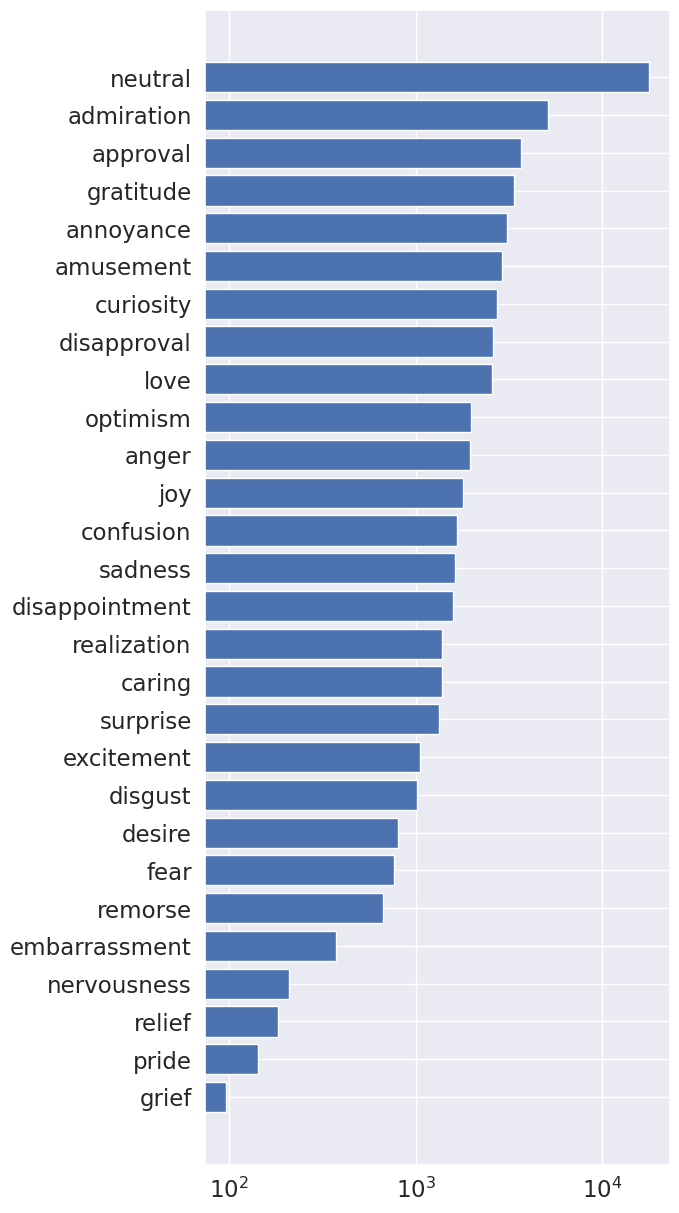

In [ ]:
all_labels = np.array(dataset['test']['labels'] + dataset['train']['labels'] + dataset['validation']['labels'])
all_labels = np.concatenate(all_labels)
print(len(all_labels))
labels_count = [np.sum(np.where(all_labels == l, 1, 0)) for l in range(0,28)]
ind = np.argsort(labels_count)
print(ind)
plt.figure(figsize = (6,15))
print(np.array(labels_count)[ind])
plt.barh(np.arange(28), np.array(labels_count)[ind], tick_label = np.array(LABELS)[ind], orientation = 'horizontal', log = True)
plt.savefig('label_distribution.pdf')
